# INF8775 – Analyse et conception d’algorithmes
# TP1 – Hiver 2021

Lamarche, Félix, 2077446

Kian, Sara, 2264793

Note finale : 13.5/20

 <u>**Date limite de remise :**</u>  21 Février 23h59 (Groupe B1), 13 février 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte. 

- Les questions et tâches à effectuées sont généralement indiquées par un TODO, mais lisez attentivement car nous pourrions avoir oublié d'en indiquer certaines.

- Des questions sont réutilisées d'un algorithme à l'autre (puisque l'on reproduit les expérimentations à des fins de comparaisons). Veillez à suffisament développer les premières réponses afin de l'on comprenne bien votre raisonnement et pour montrer votre bonne compréhension. Vous pourrez être plus concis par la suite.

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l’analyse empirique et hybride des algorithmes. Dans les capsules vidéo de la semaine 3, trois approches d’analyse de l’implantation d’un algorithme sont décrites. Vous les mettrez en pratique pour des algorithmes de résolution d’un problème connu.


## Description du problème

On vous demande de résoudre le problème de la ligne d’horizon (The Skyline Problem) qui consiste à dessiner la silhouette de bâtiments lorsqu’ils sont vus de loin. Ces bâtiments sont juxtaposés l’un à l’autre et il est possible que l’un en cache un autre.

Chaque bâtiment est défini par le triplet `(l, r, h)` avec `h` la hauteur du bâtiment et `l` et `r` les abscisses des murs gauche et droit, respectivement.

La solution représente une suite de couples `(x, h)` représentant les coordonnées des points définissant la silhouette des bâtiments.

Soit l’exemple suivant avec 5 bâtiments :

- L'exemplaire est : `(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10),
(19, 24, 8)`
- La solution est : `(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)`

La figure B représente la silhouette (et donc la solution) tracée par les bâtiments colorés de la figure A.

In [2]:
# Problem data
example_buildings = [(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10), (19, 24, 8)]

# Solution data
example_skyline = [(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)]

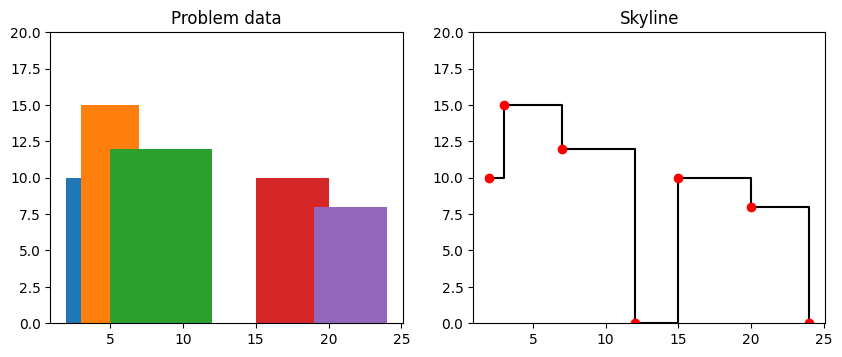

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots with equal width
fig, axs = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 1]})

# Create the first subplot to show the problem data as colored filled rectangles
for building in example_buildings:
 left, right, height = building
 axs[0].fill([left, right, right, left], [0, 0, height, height])

axs[0].set_ylim([0, 20])
axs[0].set_aspect('equal')
axs[0].set_title('Problem data')

# Create the second subplot to plot the skyline as a staircase function
x = [x for x, _ in example_skyline]
y = [y for _, y in example_skyline]
axs[1].step(x, y, where='post', color='black')

# Add the solution points as red dots
axs[1].plot(x, y, 'ro')

axs[1].set_ylim([0, 20])
axs[1].set_aspect('equal')
axs[1].set_title('Skyline')

plt.show()


## Algorithmes à implanter

On vous demande de résoudre ce problème de 3 façons différentes :

1. En utilisant un algorithme force brute simple ;
2. En utilisant un algorithme diviser pour régner ;
3. En utilisant un algorithme diviser pour régner avec seuil de récursivité non élémentaire.

Pour l’algorithme 3, vous devrez déterminer un seuil de récursivité expérimentalement. Les exemplaires dont la taille est en deçà de ce seuil ne sont plus résolus récursivement mais plutôt directement avec l’algorithme 1.

Vos algorithmes doivent donner des réponses où les couples `(x, h)` sont triés de façon non décroissante selon x (cf. exemple plus haut). Par ailleurs, ils ne doivent pas donner de solutions avec couples redondants, i.e. deux couples qui se suivent ne peuvent pas avoir la même hauteur ni la même abscisse. 


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [4]:
import random

right_bound = 50
max_dist = 30
max_height = 300

def generate_sample(size):
    sample = []
    last_l = 0
    for _ in range(size):
        l = random.randint(last_l, last_l + max_dist)
        r = random.randint(l+1, l + right_bound)
        h = random.randint(1, max_height)
        sample.append((l, r, h))
        last_l = l
    return sample

def get_dataset(seed, sizes):
    random.seed(seed)
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [5]:
import time
from scipy.stats import linregress

def verification_plot(buildings, skyline):
    # Create a figure and a set of subplots with equal width
    fig, ax = plt.subplots(figsize=(10,5))

    # Create the first subplot to show the problem data as colored filled rectangles
    for building in buildings:
        left, right, height = building
        ax.fill([left, right, right, left], [0, 0, height, height])

    # Create the second subplot to plot the skyline as a staircase function
    x = [x for x, _ in skyline]
    y = [y for _, y in skyline]
    ax.step(x, y, where='post', color='black')

    # Add the solution points as red dots
    ax.plot(x, y, 'ro')

    plt.show()


def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    total_time = 0
    for i in range(len(samples)):
        sample = samples[i]
        solution, compute_time = measure(procedure, sample)
        total_time += compute_time
        print(f"Computing {procedure.__name__} on sample {i+1} of size {len(sample)}...          ", end='\r')
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()
    

def display_mesures_seuil(vals):
    x = list(vals.keys())
    y = list(vals.values())
    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Seuil')
    plt.ylabel('Temps')
    plt.title('Selection du seuil')
    plt.show()

## Partie 1 : Algorithme naïf (brute force) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez un algorithme naïf pour le problème de la ligne d'horizon.

Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

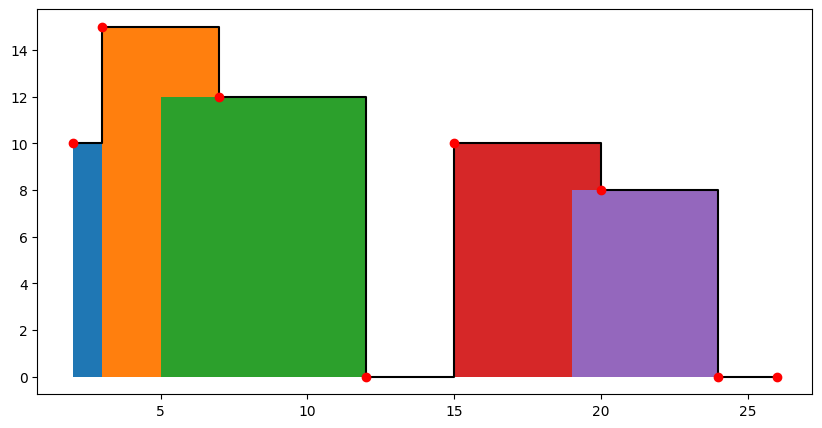

In [6]:
def skyline_bruteforce(buildings):
    right_bound = 0
    left_bound = 99999999
    for building in buildings:
        left_bound = min(building[0], left_bound)
        right_bound = max(building[1], right_bound)

    heights = [0 for _ in range(right_bound + 3 - left_bound)]

    for building in buildings:
        building_l = building[0]
        building_r = building[1]
        building_h = building[2]
        for i in range(building_l, building_r + 1):
            heights[i - left_bound] = max(heights[i - left_bound], building_h)

    skyline = []
    prev_height = 0
    for i in range(len(heights)):
        if prev_height < heights[i]:
            skyline.append([i + left_bound, heights[i]])
        elif prev_height > heights[i]:
            skyline.append([i-1 + left_bound, heights[i]])
        prev_height = heights[i]
    # Add last ground point
    skyline.append([len(heights) - 1 + left_bound, 0])
    return skyline

verification_plot(example_buildings, skyline_bruteforce(example_buildings))

[(19, 26, 145), (27, 40, 83), (27, 30, 120), (45, 77, 90), (54, 73, 105)]


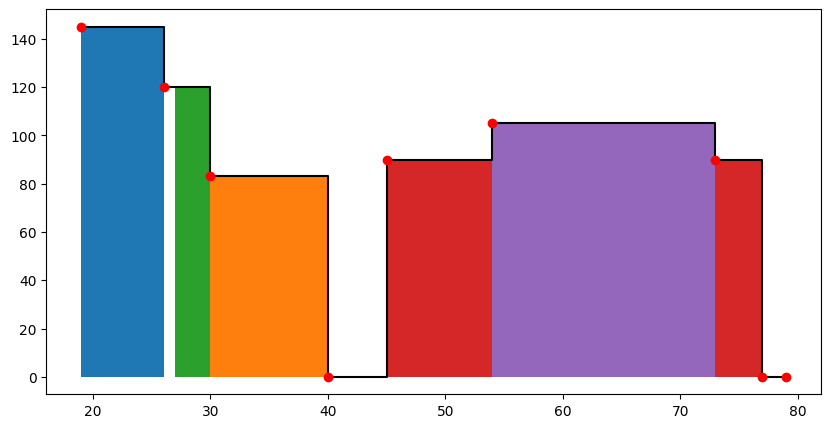

[(14, 26, 145), (8, 38, 83), (29, 32, 83), (40, 77, 90), (54, 73, 55)]


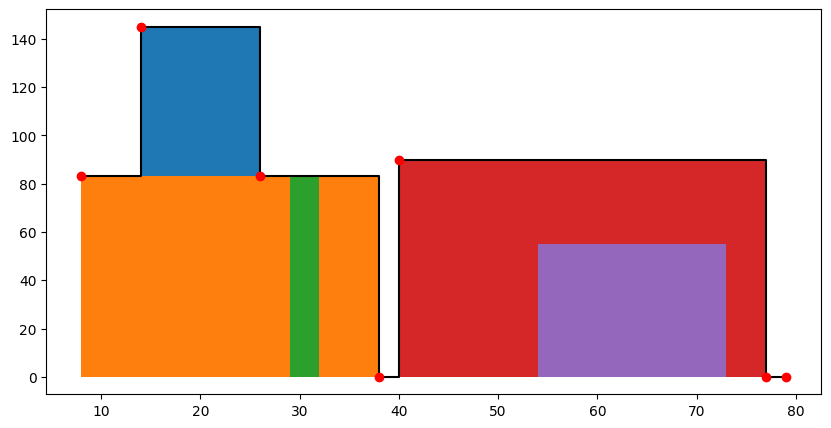

[(4, 23, 16), (16, 42, 78), (41, 88, 28), (56, 72, 276), (69, 117, 19)]


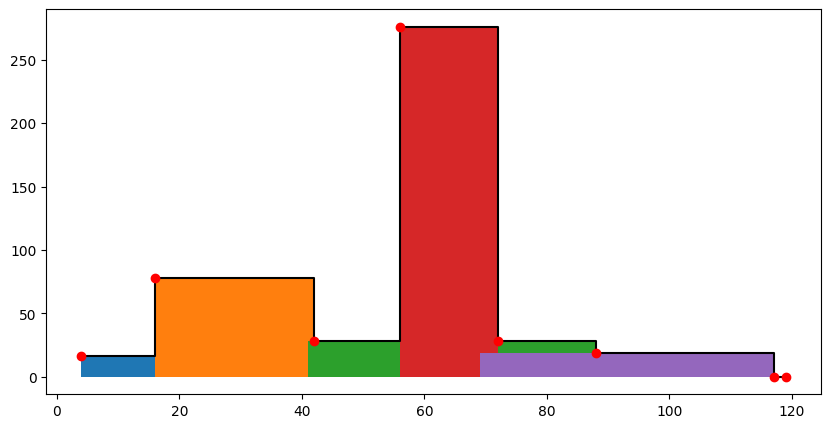

In [7]:
# AJOUT CORRECTEUR
grading_building = [(19, 26, 145), (27, 40, 83), (27, 30, 120), (45, 77, 90), (54, 73, 105)]
print(grading_building)
verification_plot(grading_building, skyline_bruteforce(grading_building))
grading_building = [(14, 26, 145), (8, 38, 83), (29, 32, 83), (40, 77, 90), (54, 73, 55)]
print(grading_building)
verification_plot(grading_building, skyline_bruteforce(grading_building))
grading_building = [(4, 23, 16), (16, 42, 78), (41, 88, 28), (56, 72, 276), (69, 117, 19)]
print(grading_building)
verification_plot(grading_building, skyline_bruteforce(grading_building))

<ul style="color:blue;font-weight:bold">
<li>Exemple OK</li>
<li>1er exemplaire KO (-0.5)</li>
<li>Même x OK</li>
<li>Même hauteur OK</li>
<li>Bâtiment englobant un autre OK</li>
</ul>

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

On pose que le nombre de bâtiments est "n" et que la largeur maximale de la ville est "m".

On itère sur chaque bâtiment pour trouver la largeur maximale de la ville (Temps de n).
Ensuite, on itère sur chaque bâtiment et dans cette boucle on itère sur la liste des hauteurs dans l'intervale de la largeur du bâtiment qui est bornée supérieurement par la largeur de la ville et pour chacun des points possibles, on fait le maximum de la hauteur du bâtiment itéré et de la hauteur présente dans la liste de hauteurs maximales (Temps de n*m maximal pour la boucle).
Finalement, on itère sur chacune des hauteurs maximales de la largeur de la ville en trouvant s'il y a une différence de hauteur entre la hauteur précédente et l'hauteur actuel pour décider si un point est nécessaire pour dessiner la ligne d'horizon (Temps de m)

La somme de temps maximal nécessaire est de: n + n*m + m.
Le temps peut donc être borné par un grand O de O(n*m).
Dans ce cas, il y a une complexité pseudo-polynomiale de O(n*m).
Dans un cas pratique avec une largeur de ville bornée, la largeur maximale la ville est une constante, alors "m" a un grand O de O(1) et l'algorithme aurait une complexité de grand O de O(n).

<ul style="color:blue;font-weight:bold">
<li>La largeur de la ville est en O(n) (bornée par n * max_dist + max_width).</li>
<li>Votre algo est pseudo-polynomial en O(n.W) ou W est la largeur maximale des bâtiments. (-1)</li>
</ul>

### Mesures

In [91]:
# TODO: Utilisez un de vos matricules comme graine et une liste de tailles judicieusement choisies
dataset = get_dataset(2077446, [512, 1024, 2048, 4096, 8192, 16384, 2**15, 2**15 + 2**14, 2**16, 2**16 + 2**15])

In [92]:
measures_bruteforce = measure_procedure(skyline_bruteforce, dataset)

Représentez vos mesures sous forme d'un tableau avec la fonction `display_measures_table`.

In [93]:
display_measures_table(measures_bruteforce)

Taille       Temps moyen (s)
512          0.010692787170410157
1024         0.021001338958740234
2048         0.04052891731262207
4096         0.07540774345397949
8192         0.1628894329071045
16384        0.2546578884124756
32768        0.5847667694091797
49152        0.9225439071655274
65536        1.1778026580810548
98304        1.8766489505767823


### Analyse hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

Pour cela complétez d'abord le code de la fonction `values_test_puissance` pour obtenir les valeurs à placer sur le graphe. Utilisez ensuite la fonction `display_test_puissance` pour afficher le graphe.

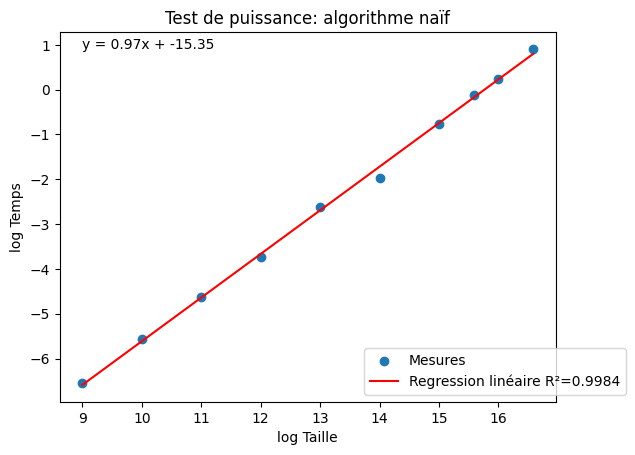

In [94]:
import math

def values_test_puissance(measures):
    return {math.log2(size): math.log2(measure) for size, measure in measures.items()}

display_test_puissance(values_test_puissance(measures_bruteforce), "Test de puissance: algorithme naïf")


<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

Le graphe a un très haut coefficient de corrélation linéaire très près de 1.
Donc, l'algorithme naif a une croissance polynomiale du degré de la pente qui est de 1.00.
Alors, il croit linéairement.

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_rapport` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_rapport` pour afficher le graphe.

In [17]:
def values_test_rapport(measures, f):
    return {size: measure/f(size) for size, measure in measures.items()}


# TODO: definissez f judicieusement
# Ici, il y a une croissance linéaire, donc f(x) = x
def f(x):
    return x

display_test_rapport(values_test_rapport(measures_bruteforce, f))

NameError: name 'measures_bruteforce' is not defined

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport. Précisez le critère de choix de votre ou vos fonctions.

Le graphe converge avec un f(x) = x. Le coefficient trouvé grâce au test du Rapport.
La constante de convergence est d'environ b=1.80e-5.

<ul style="color:blue;font-weight:bold">
<li>Le test du rapport confirme donc la complexité linéaire.</li>
</ul>

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_constantes` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_constantes` pour afficher le graphe.

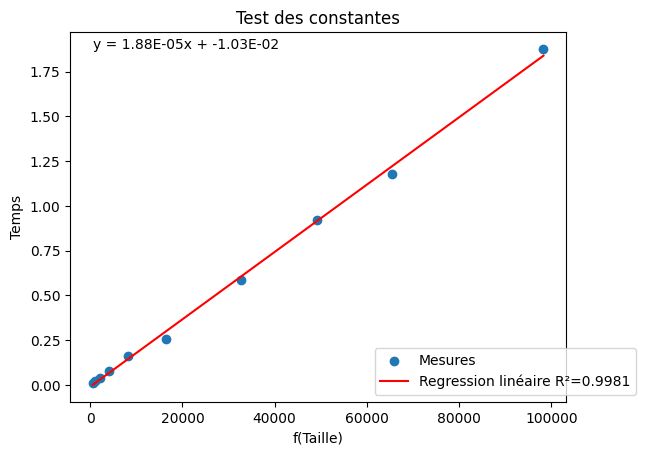

In [96]:
def values_test_constantes(measures, f):
    return { f(size): measure for size, measure in measures.items()}

def f(x):
    return x

display_test_constantes(values_test_constantes(measures_bruteforce, f))

<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

Étant donné la linéarité de l'algorithme, une bonne fonction est f(x) = x.
La constante dans l'équation "y = c * f(x) + b" est c = 1.79e-05, et b = 1.15e-0.2 qui dépend ici de mon ordinateur.


## Partie 2 : Algorithme diviser pour régner (5 pts)


<ul style="color:blue;font-weight:bold">
<li>3 /5</li>
</ul>

<u>**Question 1.a):**</u> Implantez un algorithme pour le problème de la ligne d'horizon utlisant le patron de conception "Diviser pour régner".

Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

In [10]:
def skyline_divide_and_conquer(buildings):
    # (left, right, height) = (building[0], building[1], building[2])
    # Divide the list of buildings into two and call recursively this function
    # Assumes that the buildings list is sorted by their left starting point

    lower_bound_buildings = 1


    if len(buildings) <= lower_bound_buildings:
        # Return building left and right
        return [[buildings[0][0], buildings[0][2]], [buildings[0][1], 0]]
    
    building_mid_point = len(buildings) // 2
    skyline_l = skyline_divide_and_conquer(buildings[0:building_mid_point])
    skyline_r = skyline_divide_and_conquer(buildings[building_mid_point: len(buildings)])

    # begin to merge results
    skyline = [None for point in range(len(skyline_l) + len(skyline_r))]

    l_index = 0
    r_index = 0
    s_index = 0

    l_prev_height = 0
    r_prev_height = 0
    skyline_prev_height = 0

    # While we are left of a point in the r_buildings
    while l_index < len(skyline_l) and skyline_l[l_index][0] < skyline_r[r_index][0]:
        skyline[s_index] = skyline_l[l_index]
        skyline_prev_height = skyline[s_index][1]
        l_prev_height = skyline_prev_height
        l_index += 1
        s_index += 1
    

    # the left_building and right_buildings have started overlapping
    while l_index < len(skyline_l) and r_index < len(skyline_r):
        point_l = skyline_l[l_index]
        point_r = skyline_r[r_index]

        # point_l is before point_r
        if point_l[0] < point_r[0]:
            if point_l[1] > skyline_prev_height:
                skyline[s_index] = point_l
                skyline_prev_height = skyline[s_index][1]
                l_prev_height = skyline_prev_height
                l_index += 1
                s_index += 1
            else: # point_l is under the current skyline
                if l_prev_height < r_prev_height and point_l[1] < r_prev_height:
                    l_prev_height = skyline_l[l_index][1]
                    l_index += 1
                else:
                    skyline[s_index] = [point_l[0], max(r_prev_height, point_l[1])]
                    skyline_prev_height = skyline[s_index][1]
                    l_prev_height = point_l[1]
                    l_index += 1
                    s_index += 1
        else: # point_r is before point_l
            if point_r[1] > skyline_prev_height:
                skyline[s_index] = point_r
                skyline_prev_height = skyline[s_index][1]
                r_prev_height = skyline_prev_height
                r_index += 1
                s_index += 1
            else: # point_r is below the skyline
                if r_prev_height < l_prev_height and point_r[1] < l_prev_height:
                    r_prev_height = skyline_r[r_index][1]
                    r_index += 1
                else:
                    skyline[s_index] = [point_r[0], max(l_prev_height, point_r[1])]
                    skyline_prev_height = skyline[s_index][1]
                    r_prev_height = point_r[1]
                    r_index += 1
                    s_index += 1            

    # Complete the skyline with the leftover points
    while r_index < len(skyline_r):
        skyline[s_index] = skyline_r[r_index]
        r_index += 1
        s_index += 1
    while l_index < len(skyline_l):
        skyline[s_index] = skyline_l[l_index]
        l_index += 1
        s_index += 1

    return [skyline_point for skyline_point in skyline if skyline_point is not None]

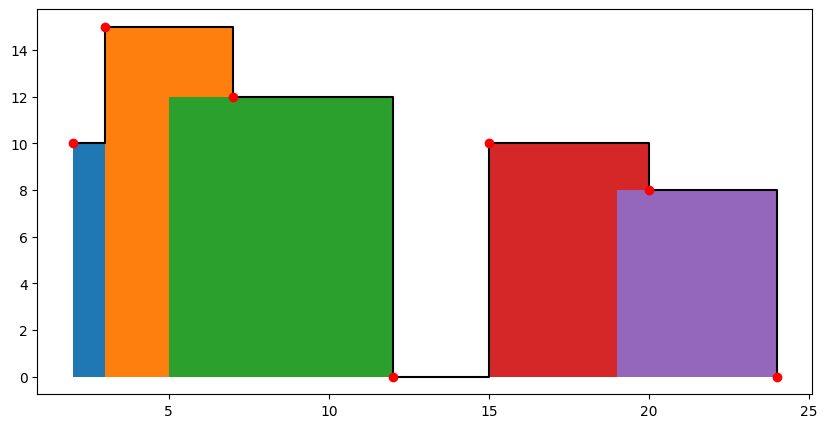

In [11]:
verification_plot(example_buildings, skyline_divide_and_conquer(example_buildings))

[(19, 26, 145), (27, 40, 83), (27, 30, 120), (45, 77, 90), (54, 73, 105)]


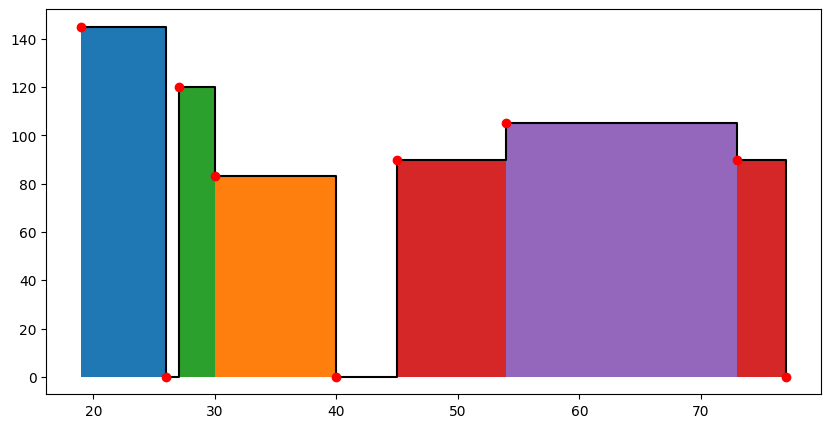

[(14, 26, 145), (8, 38, 83), (29, 32, 83), (40, 77, 90), (54, 73, 55)]


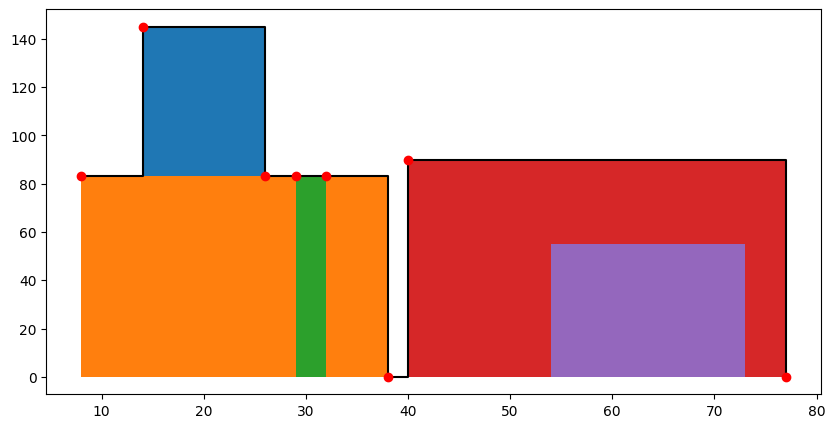

[(4, 23, 16), (16, 42, 78), (41, 88, 28), (56, 72, 276), (69, 117, 19)]


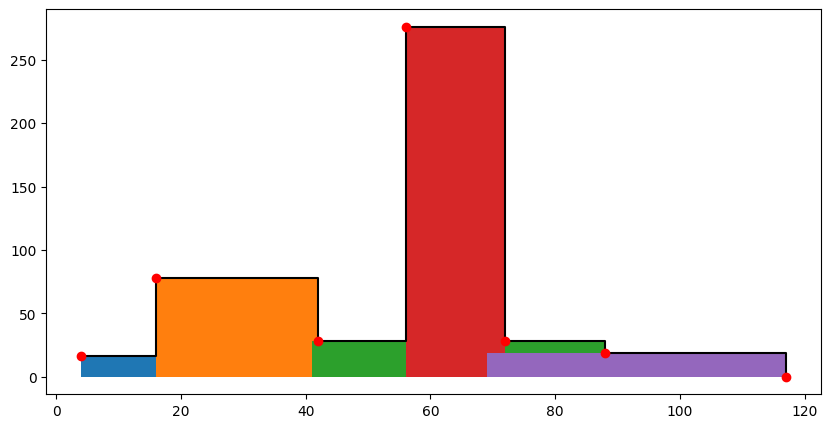

In [12]:
grading_building = [(19, 26, 145), (27, 40, 83), (27, 30, 120), (45, 77, 90), (54, 73, 105)]
print(grading_building)
verification_plot(grading_building, skyline_divide_and_conquer(grading_building))
grading_building = [(14, 26, 145), (8, 38, 83), (29, 32, 83), (40, 77, 90), (54, 73, 55)]
print(grading_building)
verification_plot(grading_building, skyline_divide_and_conquer(grading_building))
grading_building = [(4, 23, 16), (16, 42, 78), (41, 88, 28), (56, 72, 276), (69, 117, 19)]
print(grading_building)
verification_plot(grading_building, skyline_divide_and_conquer(grading_building))

<ul style="color:blue;font-weight:bold">
<li>Exemple OK</li>
<li>Même x OK</li>
<li>Même hauteur KO (-0.5)</li>
<li>Bâtiment englobant un autre OK</li>
</ul>

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

La complexité asymptotique théorique de cet algorithme peut être induit de la façon suivante:

On admet un nombre de bâtiments *n*.
L'algorithme est récursif et de type diviser et conquérir en ayant un cas de base où *n=1*.
L'appel récursif divise le nombre de bâtiments en deux, mais étant donné que le cas de base set *n=1*, le cas de base de la fonction sera appelé exactement *n* fois pour le nombre de bâtiments pour un ordre dans *Theta(n)*

Le code de merge est contenu dans un ensemble de trois boucles *while*.
Leur contenu sont similaires et contiennent des *if* et autres intstructions simples de l'ordre exact de *Theta(1)*.
Il y aura autant d'itérations que de points reçus et il y a 2 points minimalement par bâtiment.
Dans un cas minimal, il peut n'y avoir que 2 points si tous les bâtiments sont regroupés sous un seul grand bâtiment les recouvrant tous.
Pour un cas minimal de 4 itérations (2 points de l'un et 2 points de l'autres) de l'ordre de *Omaga(1)* et un cas maximal de *2n* de l'ordre de *O(n)*.

Il y a également une itération sur les points finaux pour retirés les entrées superflues qui est dans l'ordre de *Omega(1)* et *O(n)* pour la même raison que le code de merge.

En son ensemble récursif, la ligne de code de la condition du *while* sera appelée jusqu'à:
*2 points x n bâtiments = 2n* fois pour les 2 points par bâtiments au niveau supérieur.
*2 points x n/2 bâtiments x 2 appels = 2n* fois pour son niveau inférieur.
*2 points x n/4 bâtiments x 4 appels = 2n* fois pour le prochain niveau inférieur et ainsi de suite.
*2n x profondeur* et la profondeur des appels est de *log2(n)*.
Pour donner: *2n x log2(n)* appels.
Donc, l'algorithme est de l'ordre de *O(nlogn)*.

Si chaque appel récursif ne fait que garder le nombre minimal de points, la complexité est de *4 points x log2(n)* pour les appels de boucles et la complexité est bornée par un *Omega(n)* des appels de profondeur maximale.


<ul style="color:blue;font-weight:bold">
<li>Je n'ai pas vraiment compris le dernier paragraphe, mais j'ai trouvé la réponse juste dans l'avant-dernier paragraphe. Essayez d'être plus clairs.</li>
</ul>

### Mesures (seuil 1)

In [99]:
# TODO: Utilisez un de vos matricules comme graine et une liste de tailles judicieusement choisies
dataset = get_dataset(2077446, [2048, 4096, 8192, 2**14, 2**15, 2**16, 2**17])

In [100]:
measures_divide_naive_threshold = measure_procedure(skyline_divide_and_conquer, dataset)

In [101]:
display_measures_table(measures_divide_naive_threshold)

Taille       Temps moyen (s)
2048         0.04039630889892578
4096         0.074794340133667
8192         0.21099743843078614
16384        0.4101229667663574
32768        0.7037306308746338
65536        1.8519840717315674
131072       3.011694574356079


### Analyse hybride

#### Test de puissance

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

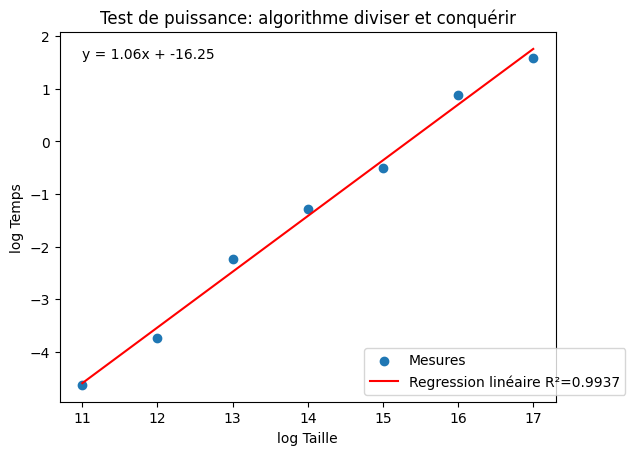

In [102]:
display_test_puissance(values_test_puissance(measures_divide_naive_threshold), "Test de puissance: algorithme diviser et conquérir")

<u>**Question 2):**</u> Analysez le graphe obtenu pour le test de puissance.

Le graphe a un haut coefficient de corrélation linéaire très près de *0.98*.
Donc, l'algorithme de division a une croissance polynomiale du degré de la pente qui est de *0.99*.
Alors, il est assez près d'une croissance linéaire, ce qui est possible selon l'analyse asymptotique fait précédemment.

<ul style="color:blue;font-weight:bold">
<li>La pente est de 1.06, ce qui est > 1 et donc cohérent avec O(n log n) (-1)</li>
</ul>

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

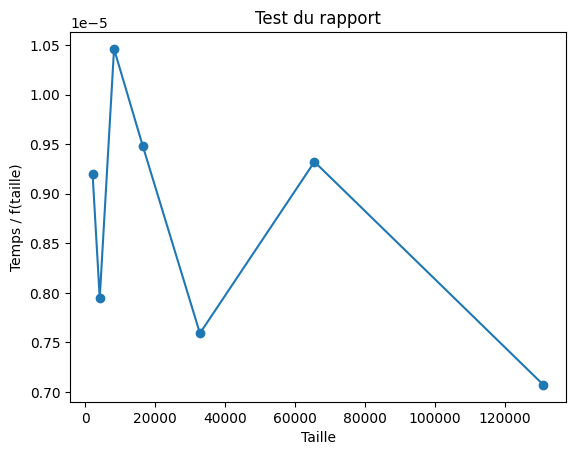

In [103]:
# TODO: définissez f judicieusement
# Défini selon le test de puissance
def f(x):
    return x**1.1

display_test_rapport(values_test_rapport(measures_divide_naive_threshold, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport.

Le graphe converge avec *f(x) = x^1.1*. Le coefficient trouvé grâce au test du Rapport puis légérement raffiné.
La constante de convergence est d'environ b=0.65e-5.

<ul style="color:blue;font-weight:bold">
<li>OK, mais il valait mieux tester avec f(x) = log(x), car c'est votre analyse théorique validée par le test de puissance. (-0.25)</li>
</ul>

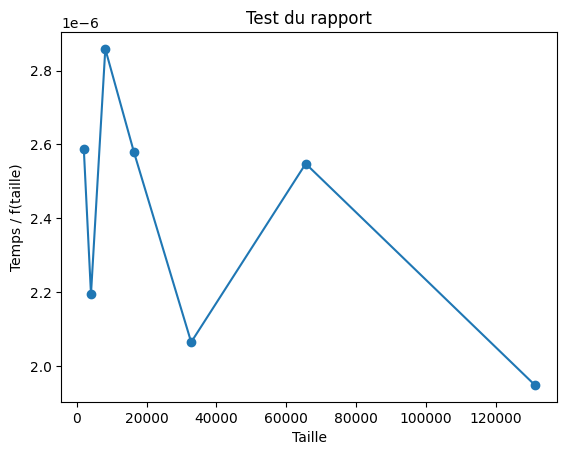

In [22]:
import math
# Tableau de données
data = [
    (2048,  0.04039630889892578),
    (4096,  0.074794340133667),
    (8192,  0.21099743843078614),
    (16384,  0.4101229667663574),
    (32768,  0.7037306308746338),
    (65536,  1.8519840717315674),
    (131072,  3.011694574356079)
]

# Conversion du tableau en dictionnaire
measures_divide_naive_threshold = {size: time for size, time in data}

# AJOUT CORRECTEUR
# Défini selon le test de puissance
def f(x):
    return x*math.log(x)

display_test_rapport(values_test_rapport(measures_divide_naive_threshold, f))

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

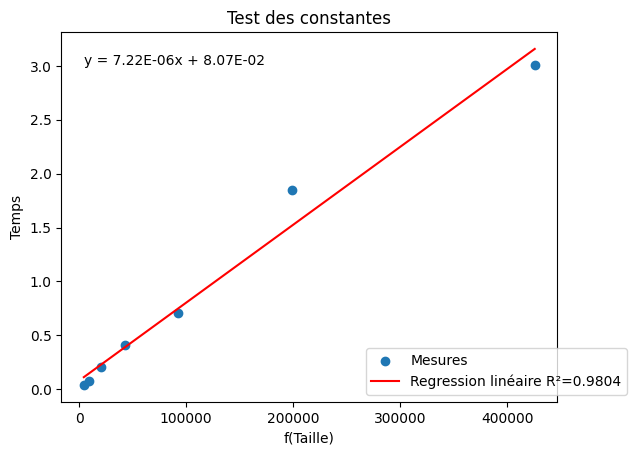

In [104]:
# TODO: définissez f judicieusement
def f(x):
    return x**1.1

display_test_constantes(values_test_constantes(measures_divide_naive_threshold, f))

<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

Étant donné la linéarité de l'algorithme, une bonne fonction est *f(x) = x^1.1*.
La constante dans l'équation *y = c * f(x) + b* est *c = 6.26e-06*, et *b = 6.59e-02* qui dépend ici de mon ordinateur.
La corrélation du graphe est assez forte avec un coefficient de *0.99* et la constante de la pente est plus basse que celle de l'algorithme naif, mais son origine est légérement supérieure.

<ul style="color:blue;font-weight:bold">
<li>Même remarque pour f(x) = log(x). (-0.25)</li>
</ul>

## Partie 3 : Algorithme diviser pour régner (seuil arbitraire) (5 pts)

<ul style="color:blue;font-weight:bold">
<li>3 /5</li>
</ul>

### Selection du seuil

<u>**Question 1.a):**</u> Modifiez l'algorithme précédent pour y ajouter un seuil de récursivité (e.g. `threshold`). En dessous de ce seuil, vous utiliserez l'algorithme naïf écrit précédemment.

In [105]:
def skyline_divide_and_conquer_threshold(buildings, threshold=1):
    # (left, right, height) = (building[0], building[1], building[2])
    # Divide the list of buildings into two and call recursively this function
    # Assumes that the buildings list is sorted by their left starting point

    # After reaching the threshold, use the naive algorithm
    if len(buildings) <= threshold:
        # Return building left and right
        return skyline_bruteforce(buildings)
    
    building_mid_point = len(buildings) // 2
    skyline_l = skyline_divide_and_conquer_threshold(buildings[0:building_mid_point])
    skyline_r = skyline_divide_and_conquer_threshold(buildings[building_mid_point: len(buildings)])

    # begin to merge results
    skyline = [None for point in range(len(skyline_l) + len(skyline_r))]

    l_index = 0
    r_index = 0
    s_index = 0

    l_prev_height = 0
    r_prev_height = 0
    skyline_prev_height = 0

    # While we are left of a point in the r_buildings
    while l_index < len(skyline_l) and skyline_l[l_index][0] < skyline_r[r_index][0]:
        skyline[s_index] = skyline_l[l_index]
        skyline_prev_height = skyline[s_index][1]
        l_prev_height = skyline_prev_height
        l_index += 1
        s_index += 1
    

    # the left_building and right_buildings have started overlapping
    while l_index < len(skyline_l) and r_index < len(skyline_r):
        point_l = skyline_l[l_index]
        point_r = skyline_r[r_index]

        # point_l is before point_r
        if point_l[0] < point_r[0]:
            if point_l[1] > skyline_prev_height:
                skyline[s_index] = point_l
                skyline_prev_height = skyline[s_index][1]
                l_prev_height = skyline_prev_height
                l_index += 1
                s_index += 1
            else: # point_l is under the current skyline
                if l_prev_height < r_prev_height and point_l[1] < r_prev_height:
                    l_prev_height = skyline_l[l_index][1]
                    l_index += 1
                else:
                    skyline[s_index] = [point_l[0], max(r_prev_height, point_l[1])]
                    skyline_prev_height = skyline[s_index][1]
                    l_prev_height = point_l[1]
                    l_index += 1
                    s_index += 1
        else: # point_r is before point_l
            if point_r[1] > skyline_prev_height:
                skyline[s_index] = point_r
                skyline_prev_height = skyline[s_index][1]
                r_prev_height = skyline_prev_height
                r_index += 1
                s_index += 1
            else: # point_r is below the skyline
                if r_prev_height < l_prev_height and point_r[1] < l_prev_height:
                    r_prev_height = skyline_r[r_index][1]
                    r_index += 1
                else:
                    skyline[s_index] = [point_r[0], max(l_prev_height, point_r[1])]
                    skyline_prev_height = skyline[s_index][1]
                    r_prev_height = point_r[1]
                    r_index += 1
                    s_index += 1            

    # Complete the skyline with the leftover points
    while r_index < len(skyline_r):
        skyline[s_index] = skyline_r[r_index]
        r_index += 1
        s_index += 1
    while l_index < len(skyline_l):
        skyline[s_index] = skyline_l[l_index]
        l_index += 1
        s_index += 1

    return [skyline_point for skyline_point in skyline if skyline_point is not None]

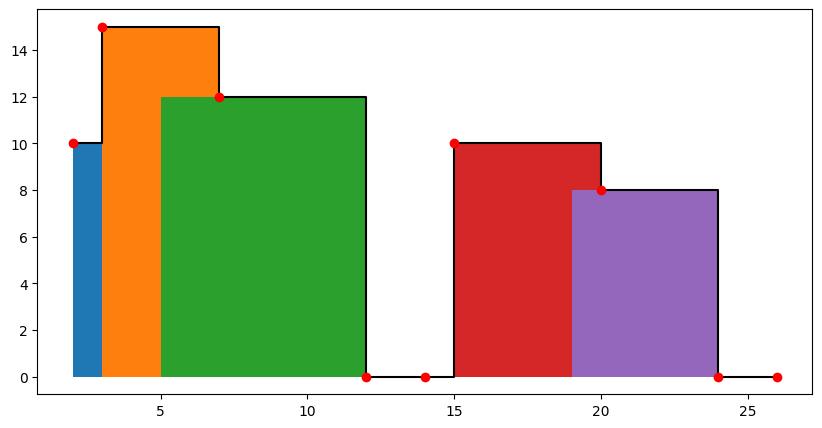

In [106]:
verification_plot(example_buildings, skyline_divide_and_conquer_threshold(example_buildings))

<u>**Question 1.b):**</u> Effectuez les mesures avec plusieurs seuils de récursivité pour déterminer le seuil le plus judicieux.

In [121]:
buildings_divide_and_conquer = [generate_sample(512), generate_sample(1024), generate_sample(2048), generate_sample(4096), generate_sample(8192)]
# sizes_d_a_c, samples_d_a_c = dataset.items()
measures_threshold = {
    i:
    measure_mean_time(
        lambda sample: skyline_divide_and_conquer_threshold(sample, i),
        buildings_divide_and_conquer) # TODO: sélectionnez un exemplaire 
        for i in [1,2,4,8,16,32,64,96,128,192,256] # TODO: testez une liste judicieuse de seuils
}


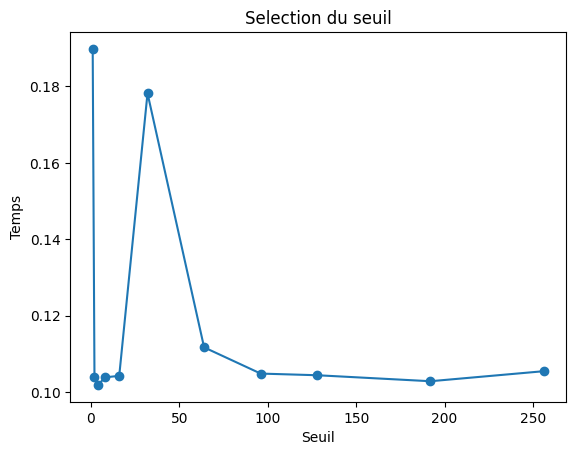

In [122]:
display_mesures_seuil(measures_threshold)

<u>**Question 1.c):**</u> Quel est le seuil de récursivité de le plus judicieux ? Sur quel critère l'avez vous sélectionné ? Pourquoi des seuils inférieurs ou supérieurs donnent-ils de moins bonnes performances ?

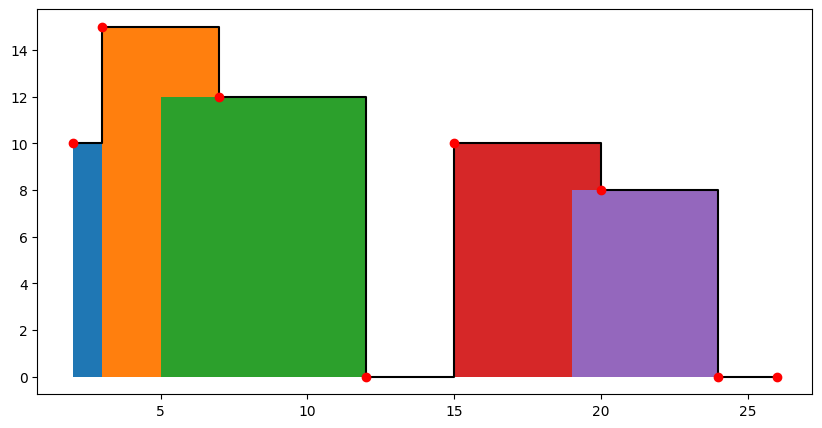

In [123]:
best_threshold = 32
verification_plot(example_buildings, skyline_divide_and_conquer_threshold(example_buildings, best_threshold))

Un seuil de récursivité de *32* semble adéquat et être un seuil assez conservatif.
Le seuil ici dépend beaucoup de notre algorithme naif.
Notre algorithme naif fonctionne bien pour des assortiments de beaucoup de bâtiments dans un petit espace. Puisque l'algorithme prend en compte le domaine de la largeur des bâtiments.
Alors, avoir un seuil très bas serait inefficace et un large seuil pourrait devenir plus inefficace.
Cependant, notre algorithme naif croit linéairement, donc une bonne façon d'obtenir un seuil est expérimentalement en analysant le graphe des différents seuils.
Étant donné la croissance linéaire de l'algorithme naif, un seuil supérieur ne va pas décroitre la performance de l'algorithme,
mais un seuil très bas ne sera pas efficace par le fait que le cas est très simple et ne prend pas avantage de l'algorithme.

<ul style="color:blue;font-weight:bold">
<li>On cherhait le seuil pour lequel le temps est minimal dans le graphe précédent. 32 pourrait même être un pic ici. (-1)</li>
</ul>

<u>**Question 1.d):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

En se référant à l'analyse de la complexité asymptotique de la question 2 (diviser et conquérir), on peut voir que l'analyse sera très similaire.
La grande différence provient du seuil de récursivité qui réduit le nombre de *merge* qui sera produit.

Le seuil fait en sorte que le cas de base de récursivité se produira *n/32* fois.
L'algorithme naif qui est de l'ordre de *O(n)*, quoi qu'ici il itère communément sur l'ensemble des bâtiments.
Donc, en tout, le travail doit se dérouler sur l'ensemble *n*, puisque chaque bâtiment est traité exactement une fois.
Donc, l'ensemble des appels à l'algorithme naif doit rouler en ordre de *Theta(n)*.

La section de *merge* sera appelé environ *n/32* fois également pour qu'il itère sur les bâtiments pour rester dans l'ordre de *O(nlogn)* comme démontré précédemment.
Puisque la seule chose ayant changé est une constante qui est un facteur de division.

Donc, l'algorithme fonctionne donc en temps de *O(nlogn)*.

<ul style="color:blue;font-weight:bold">
<li>Bien plus clair que dans la partie précédente.</li>
</ul>

### Mesures (seuil n)

In [124]:
dataset = get_dataset(2077446, [1024, 2048, 4096, 8192, 16384])
measures_divide_best_threshold = measure_procedure(lambda sample : skyline_divide_and_conquer_threshold(sample, best_threshold), dataset)

In [125]:
display_measures_table(measures_divide_best_threshold)

Taille       Temps moyen (s)
1024         0.051397275924682614
2048         0.08282957077026368
4096         0.15694069862365723
8192         0.32936458587646483
16384        0.6505395889282226


### Analyse hybride

#### Test de puissance

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

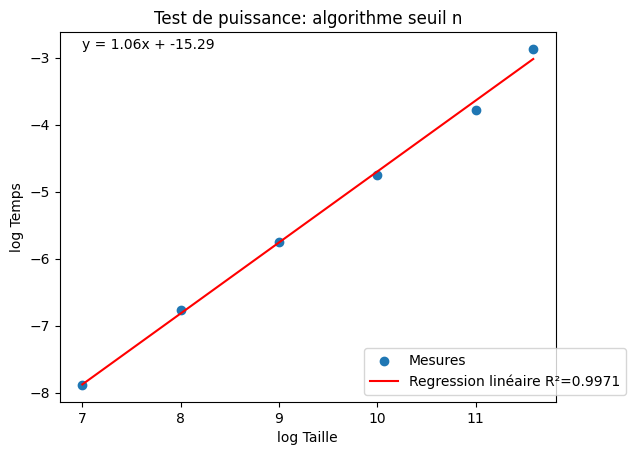

In [112]:
display_test_puissance(values_test_puissance(measures_divide_best_threshold), "Test de puissance: algorithme seuil n")

<u>**Question 2):**</u> Analysez le graphe obtenu pour le test de puissance.

Il y a un coefficient de régression linéaire très élevé de *0.99* ce qui montre une très probabilité du coefficient.
Le facteur de puissance est de *1.06* ce qui est polynomial est très près d'être une croissance linéaire.
Donc, il peut être de l'ordre de *O(nlogn)*.

<ul style="color:blue;font-weight:bold">
<li>Meilleure réponse que la partie précédente encore une fois. Je préférerais "très près mais strictement au dessus d'une croissance linéaire"</li>
</ul>

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

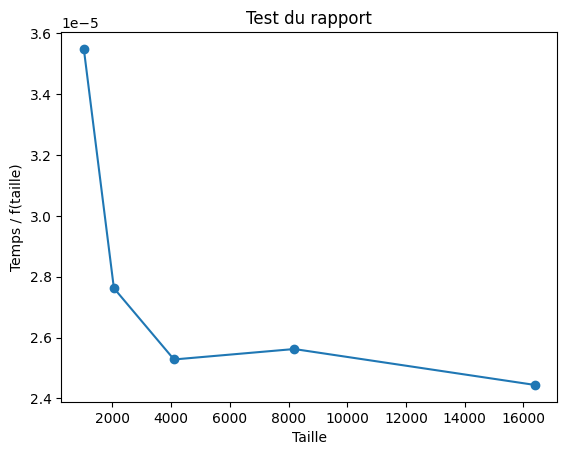

In [126]:
# TODO: définissez f judicieusement
def f(x):
    return x**1.05

display_test_rapport(values_test_rapport(measures_divide_best_threshold, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport.

Le graphe converge avec *f(x) = x^1.05*. Le coefficient trouvé grâce au test du Rapport.
La constante de convergence est d'environ b=2.5e-5.

<ul style="color:blue;font-weight:bold">
<li>Il fallait choisir f(x) = x * log (x) (-0.25)</li>
</ul>

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

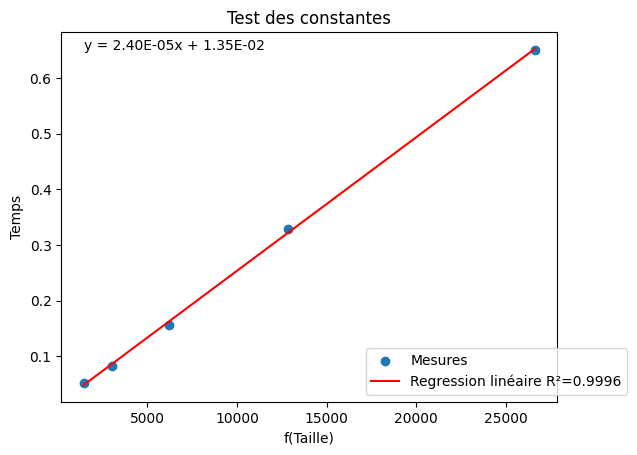

In [127]:
# TODO: définissez f judicieusement
def f(x):
    return x**1.05

display_test_constantes(values_test_constantes(measures_divide_best_threshold, f))


<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

Une bonne fonction est *f(x) = x^1.05*.
La constante dans l'équation *y = c * f(x) + b* est *c = 2.4e-05*, et *b = 1.32e-02* qui dépend ici de mon ordinateur.
La corrélation du graphe est assez forte avec un coefficient de *0.99*.

<ul style="color:blue;font-weight:bold">
<li>Il fallait choisir f(x) = x * log (x) (-0.25)</li>
</ul>

<u>**Question 5):**</u> Commentez l'impact du seuil de récursivité. Que représente t'il pour l'algorithme diviser pour régner et l'algorithme naïf ?

Le seuil de récursivité représente la profondeur maximale de l'algorithme diviser pour régner et influence le nombre de fois que l'algorithme naif sera roulé.
Plus haut le seuil se trouve, le moins que l'algorithme naif sera appelé, mais plus grand sera ses ensembles de données à traiter.
Et moins l'algorithme naif est appelé, moins il y a de *merging* des différents appels récursifs.

<ul style="color:blue;font-weight:bold">
<li>Les éléments de réponses attendus : le seuil ne change pas le comportement asymptotique (-0.25), il représente la taille d'exemplaire pour laquelle le naif et le diviser pour regner prennent le même temps (-0.25)</li>
</ul>

# Conclusion (3 pts)

Résumez *brièvement* vos découvertes et analyses, et indiquez dans quelles circonstances vous utiliserez chacun de ces 3 algorithmes.

L'algorithme naif semblait rouler rapidement, mais cela se produit puisque les bâtiments ont une largeur négligable. Si nous avions un cas où les bâtiments étaient de plusieurs milliers d'units de longs, l'algorithme naif serait plus lent, puisqu'il est d'ordre pseudo-linéaire. Sa linéarité dépend de la nature des données. Il serait très apte à résoudre des problèmes avec beaucoup de bâtiments, et il performe mieux, le plus petit sont ces bâtiments.

L'algorithme diviser pour régner, est d'ordre de *O(nlogn)* et ne dépend que du nombre de bâtiments en entrée. Il serait donc efficace pour des problèmes de toute taille, il est efficace à l'échelle.

L'algorithme diviser pour régner avec un seuil de récursivité dépend beaucoup de l'algorithme naif utilisé une fois le seuil atteint. Ici, cet algorithme dépend énormément de la nature des données. Il est d'ordre de *O(nlogn)*, et est efficace avec un seuil élevé. Il est donc efficace de l'utiliser pour de grands problèmes en prenant en compte la nature des données (les bâtiments doivent être près avec de petites largeurs).

<ul style="color:blue;font-weight:bold">
<li>L'algorithme diviser pour régner a le même comportement asymptotique quelque soit le seuil choisi, 1 ou le meilleur sélectionné. Il n'y a pas de raison d'utiliser un seuil trivial si on connaît le meilleur seuil (-1)</li>
</ul>

 ## Autres critères (2 pts)
 Qualité du code 1 / 1 pt

Présentation générale 1 / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -1 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.